# U-Net Performance and relevant ablation studies

## Aggregated Results

In [142]:
import os
import torch
import pandas as pd
import seaborn as sns


directory = '../../results/unet/'
data = {}
for file in os.listdir(directory):
    if '.pt' in file:
        data[file[:-3]] = torch.load(directory + file)
        
data['ae_heart'] = np.load(directory+'ae_heart.npy',allow_pickle=True).item()

In [143]:
# Create a pandas DataFrame from the nested dictionary
df = pd.DataFrame(columns=['organ', 'domain', 'model', 'it', 'dsc'])

# Parse and populate the DataFrame
for top_key, sub_dict in data.items():
    model, organ = top_key.split('_')
    for domain, values in sub_dict.items():
        if isinstance(values, torch.Tensor):
            for it, dsc in enumerate(values):
                row = pd.DataFrame({
                    'organ': organ,
                    'domain': domain,
                    'model': model,
                    'it': it,
                    'dsc': dsc.item()
                }, index=[0])
                df = pd.concat([df, row], ignore_index=True)
    
        elif isinstance(values, list):
            for it, dsc in enumerate(values):
                row = pd.DataFrame({
                    'organ': organ,
                    'domain': domain,
                    'model': model,
                    'it': it,
                    'dsc': dsc
                }, index=[0])
                df = pd.concat([df, row], ignore_index=True)        
                
        else:
            row = pd.DataFrame({
                'organ': organ,
                'domain': domain,
                'model': model,
                'it': 0,
                'dsc': values
            }, index=[0])
            df = pd.concat([df, row], ignore_index=True)

df.head()  # Display the first few rows of the DataFrame

,organ,domain,model,it,dsc
0,heart,acdc_train,baseline,0,0.923220
1,heart,acdc_train,baseline,1,0.923347
2,heart,acdc_train,baseline,2,0.911828
3,heart,acdc_train,baseline,3,0.911891
4,heart,acdc_train,baseline,4,0.928071


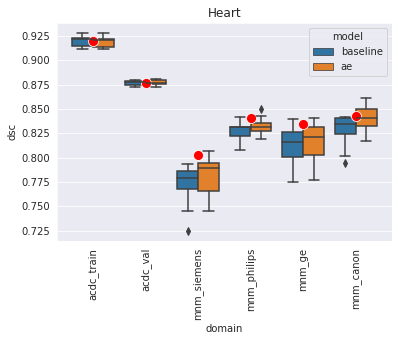

In [151]:
sns.boxplot(
    data=df[(df['model'] != 'ablation') & (df['organ'] == 'heart')], 
    x='domain', 
    y='dsc',
    hue='model'
)
sns.scatterplot(
    data=df[(df['model'] == 'ablation') & (df['organ'] == 'heart')], 
    x='domain', 
    y='dsc', 
    marker="o", 
    s=100,
    c='red',
#     hue='domain',
    legend=False
)

plt.xticks(rotation=90)
plt.title('Heart')
plt.savefig('../../assests/heart_domain_adaptation.png', bbox_inches='tight', dpi=400, transparent=False)

In [165]:
# sorting dice scores to find average unet
print(df[df['organ'] == 'brain'].groupby('it').mean().sort_values('dsc'))
print(df[df['organ'] == 'heart'].groupby('it').mean().sort_values('dsc'))

         dsc
it          
1   0.951932
7   0.954599
8   0.970577
6   0.971160
0   0.971397
4   0.973400
3   0.973850
2   0.974122
5   0.974726
9   0.976184
         dsc
it          
3   0.822882
8   0.824735
5   0.834156
1   0.842794
6   0.844521
7   0.847788
4   0.849588
2   0.849634
0   0.850756
9   0.852914


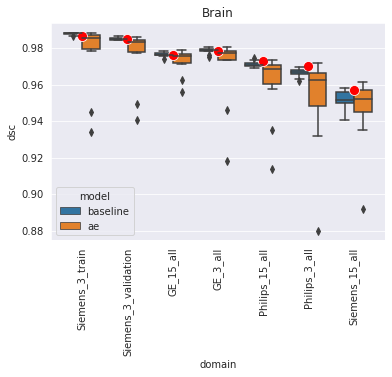

In [152]:
sns.set_style("darkgrid")

sns.boxplot(
    data=df[(df['model'] != 'ablation') & (df['organ'] == 'brain')], 
    x='domain', 
    y='dsc',
    hue='model'
)
sns.scatterplot(
    data=df[(df['model'] == 'ablation') & (df['organ'] == 'brain')], 
    x='domain', 
    y='dsc', 
    marker="o", 
    s=100,
    c='red',
#     hue='domain',
    legend=False
)

plt.xticks(rotation=90)
plt.title('Brain')
plt.savefig('../../assests/Brain_domain_adaptation.png', bbox_inches='tight', dpi=400, transparent=False)

## Imports and Definitions

In [132]:
import matplotlib.pyplot as plt
import os, sys
from typing import (
    Iterable,
    Dict,
    List,
    Callable,
    Tuple,
    Union,
    List
)
import numpy as np
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter


sys.path.append('../')
from dataset import (
    CalgaryCampinasDataset, 
    MNMDataset, 
    ACDCDataset
)
from model.unet import UNet2D
from losses import (
    DiceScoreCalgary,
    SurfaceDiceCalgary,
    DiceScoreMMS
)
from utils import epoch_average, volume_collate
from trainer.unet_trainer import UNetTrainerCalgary, UNetTrainerACDC
from data_utils import (
    get_subset,
    Transforms,
    MultiImageSingleViewDataLoader
)
from model.dae import AugResDAE
from model.wrapper import ModelAdapter

In [12]:
@torch.no_grad()
def get_dice_for_brain(
    dataset,
    model: nn.Module,
    criterion: nn.Module,
    device: str = 'cuda:0',
    batch_size: int = 1
):
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False
    )
    
    # collect evaluation per slice and cache
    #assert criterion.reduction == 'none'
    model.eval()
    loss_list = []
    for batch in dataloader:
        input_  = batch['input'].to(device)
        target  = batch['target'].to(device)
        net_out = (torch.sigmoid(model(input_)) > 0.5) * 1
        loss    = criterion(
            net_out,
            target
        ).view(input_.shape[0], -1).mean(1)
        
        loss_list.append(loss)
        
    return torch.cat(loss_list, dim=0).cpu()



@torch.no_grad()
def get_dice_for_heart(
    dataset,
    model: nn.Module, 
    criterion: nn.Module,
    device: str = 'cuda:0',
    batch_size: int = 1
):   
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False,
        drop_last=False
    )
    
    model.eval()
    # saves batch sizes for each batch for averaging
    loss_list = []
    for batch in dataloader:
        input_ = batch['input'].to(device)
        target = batch['target'].to(device)
        # convert -1 labels to background
        target[target == -1] = 0
        # convert to one-hot encoding
        target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
        # get model output and compute loss
        net_out = model(input_)
        loss    = criterion(
            net_out,
            target
        ).view(input_.shape[0], -1).mean(1)
        loss_list.append(loss)
        
    return torch.cat(loss_list, dim=0).cpu()

## Calgary Campinas

### U-Nets

In [136]:
# U-Nets
post = ''
middle = 'unet'
pre = 'calgary'
unet_names = [f'{pre}_{middle}{i}' for i in range(10)]
unets = []

for name in unet_names:
    model_path = f'{ROOT}pre-trained/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    unet = UNet2D(
        n_chans_in=1, 
        n_chans_out=1, 
        n_filters_init=8, 
        dropout=False
    )
    unet.load_state_dict(state_dict)
    unets.append(unet)
    

model_path = f'{ROOT}pre-trained/trained_UNets/calgary_unet0_ablation_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
unet_all_transforms = UNet2D(
        n_chans_in=1, 
        n_chans_out=1, 
        n_filters_init=8, 
        dropout=False
    )
unet_all_transforms.load_state_dict(state_dict)

<All keys matched successfully>

### AEs

In [137]:
disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
DAEs = nn.ModuleDict(
    {'up3': AugResDAE(
        in_channels = 64, 
        in_dim      = 32,
        latent_dim  = 256,
        depth       = 3,
        block_size  = 4)
    }
)

for layer_id in disabled_ids:
    DAEs[layer_id] = nn.Identity()

aes = []
    
for i, unet in enumerate(unets):
    model = ModelAdapter(
        seg_model=unet,
        transformations=DAEs,
        disabled_ids=disabled_ids,
        copy=True
    )
    
    model_path = f'{ROOT}pre-trained-tmp/trained_AEs/calgary_AugResDAE{i}_localAug_multiImgSingleView_res_balanced_same_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    model.load_state_dict(state_dict)
    model.hook_inference_transformations(model.transformations, n_samples=-1)
    model.eval()
    aes.append(model)

### Full Sets

In [3]:
DEBUG = False
ROOT = '../../'
DATA_PATH = '../../data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/'


In [139]:
train_and_validation = {
    split: CalgaryCampinasDataset(
        data_path=DATA_PATH, 
        site=6,
        split=split,
        augment=False, 
        normalize=True, 
        debug=DEBUG
    ) for split in ['train', 'validation']
}

test = {
    str(site): CalgaryCampinasDataset(
        data_path=DATA_PATH, 
        site=site,
        split='all',
        augment=False, 
        normalize=True, 
        debug=DEBUG
    ) for site in range(1, 6)
}

datasets = {**train_and_validation, **test}

### Subsets

not needed as of now

### Eval

In [140]:
metrics_ae_brain = {}

for key in datasets:
    scores = []
    for ae in aes:
        DSC = get_dice_for_brain(
            dataset=datasets[key],
            model=ae.cuda(),
            criterion=DiceScoreCalgary(),
            device='cuda:0',
            batch_size = 32
        )
        scores.append(DSC.mean())

    metrics_ae_brain[
        f'{datasets[key].folder}_{datasets[key].split}'
    ] = torch.tensor(scores)
    
    print(metrics_ae_brain[f'{datasets[key].folder}_{datasets[key].split}'])

tensor([0.9864, 0.9452, 0.9875, 0.9872, 0.9868, 0.9825, 0.9843, 0.9343, 0.9786,
        0.9882])
tensor([0.9835, 0.9493, 0.9853, 0.9845, 0.9837, 0.9792, 0.9834, 0.9407, 0.9771,
        0.9861])
tensor([0.9714, 0.9627, 0.9753, 0.9760, 0.9771, 0.9780, 0.9768, 0.9559, 0.9727,
        0.9790])
tensor([0.9739, 0.9183, 0.9777, 0.9787, 0.9777, 0.9790, 0.9732, 0.9460, 0.9771,
        0.9805])
tensor([0.9680, 0.9138, 0.9678, 0.9694, 0.9703, 0.9711, 0.9578, 0.9350, 0.9733,
        0.9721])
tensor([0.9604, 0.8801, 0.9642, 0.9667, 0.9676, 0.9660, 0.9546, 0.9461, 0.9319,
        0.9720])
tensor([0.9349, 0.9428, 0.9524, 0.9517, 0.9511, 0.9615, 0.9566, 0.8917, 0.9569,
        0.9580])


In [141]:
torch.save(metrics_ae_brain, '../../results/unet/ae_brain.pt')

In [6]:
metrics_baseline_brain = {}

for key in datasets:
    scores = []
    for unet in unets:
        DSC = get_dice_for_brain(
            dataset=datasets[key],
            model=unet.cuda(),
            criterion=DiceScoreCalgary(),
            device='cuda:0',
            batch_size = 32
        )
        scores.append(DSC.mean())

    metrics_baseline_brain[
        f'{datasets[key].folder}_{datasets[key].split}'
    ] = torch.tensor(scores)
    
# torch.save(metrics_baseline_brain, '../../results/unet/baseline_performance_brain.pt')

In [7]:
metrics_ablation_brain = {}

for key in datasets:
    DSC = get_dice_for_brain(
        dataset=datasets[key],
        model=unet_all_transforms.cuda(),
        criterion=DiceScoreCalgary(),
        device='cuda:0',
        batch_size = 32
    )
    metrics_ablation_brain[
        f'{datasets[key].folder}_{datasets[key].split}'
    ] = DSC.mean().item()
    
# torch.save(metrics_ablation_brain, '../../results/unet/additional_augmentations_brain.pt')

### Visualization

## ACDC / M&M Datasets

In [22]:
### - datasets
DEBUG = False
datasets = {}
# - ACDC train
acdc_train = ACDCDataset(data='train', debug=DEBUG)
datasets['acdc_train'] = acdc_train
# - ACDC val
acdc_val = ACDCDataset(data='val', debug=DEBUG)
datasets['acdc_val'] = acdc_val
# - M&M A
mnm_a = MNMDataset(vendor='A', debug=DEBUG)
datasets['mnm_siemens'] = mnm_a
# - M&M B
mnm_b = MNMDataset(vendor='B', debug=DEBUG)
datasets['mnm_philips'] = mnm_b
# - M&M C
mnm_c = MNMDataset(vendor='C', debug=DEBUG)
datasets['mnm_ge'] = mnm_c
# - M&M D
mnm_d = MNMDataset(vendor='D', debug=DEBUG)
datasets['mnm_canon'] = mnm_d

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties


## Unets

In [27]:
# U-Nets
post = ''
middle = 'unet8_'
pre = 'acdc'

unet_names = [f'{pre}_{middle}{i}' for i in range(10)]
unets = []

for name in unet_names:
    model_path = f'{ROOT}pre-trained/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    unet = UNet2D(
        n_chans_in=1, 
        n_chans_out=4, 
        n_filters_init=8, 
        dropout=False
    )
    unet.load_state_dict(state_dict)
    unets.append(unet)
    

model_path = f'{ROOT}pre-trained/trained_UNets/acdc_unet8_0_ablation_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
unet_all_transforms = UNet2D(
    n_chans_in=1,
    n_chans_out=4, 
    n_filters_init=8, 
    dropout=False
)
unet_all_transforms.load_state_dict(state_dict)

<All keys matched successfully>

### Eval

In [24]:
metrics_baseline_heart = {}

for key in datasets:
    scores = []
    for unet in unets:
        DSC = get_dice_for_heart(
            dataset=datasets[key],
            model=unet.cuda(),
            criterion=DiceScoreMMS(),
            device='cuda:0',
            batch_size = 32
        )
        scores.append(DSC.mean())

    metrics_baseline_heart[f'{key}'] = torch.tensor(scores)
    
torch.save(metrics_baseline_heart, '../../results/unet/baseline_performance_heart.pt')

In [39]:
{key: metrics_baseline_heart[key].max().item() for key in metrics_baseline_heart}

{'acdc_train': 0.9280713200569153,
 'acdc_val': 0.8797795176506042,
 'mnm_siemens': 0.7932883501052856,
 'mnm_philips': 0.8417585492134094,
 'mnm_ge': 0.8398064374923706,
 'mnm_canon': 0.8420272469520569}

In [28]:
metrics_ablation_heart = {}

for key in datasets:
    DSC = get_dice_for_heart(
        dataset=datasets[key],
        model=unet_all_transforms.cuda(),
        criterion=DiceScoreMMS(),
        device='cuda:0',
        batch_size=32
    )
    metrics_ablation_heart[f'{key}'] = DSC.mean().item()
    

In [46]:
torch.save(metrics_ablation_heart, '../../results/unet/additional_augmentations_heart.pt')

In [40]:
{key: metrics_baseline_heart[key].max().item() for key in metrics_baseline_heart}

{'acdc_train': 0.9280713200569153,
 'acdc_val': 0.8797795176506042,
 'mnm_siemens': 0.7932883501052856,
 'mnm_philips': 0.8417585492134094,
 'mnm_ge': 0.8398064374923706,
 'mnm_canon': 0.8420272469520569}